# GAN model
##### Script for training model

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model, decomposition, manifold, preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import precision_recall_curve, roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
import pickle
import time
from numpy import load
from matplotlib import pyplot
import pickle
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [ ]:
NAME="GAN-save"

### Mount googl drive

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
path='/content/drive/My Drive/praca_mgr'
os.chdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load and process data

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display
import sklearn
from sklearn.preprocessing import StandardScaler

In [ ]:
# load the dataset
data = load('./data/data_nonrandom_responses.npz')["arr_0"]
print('Loaded: ',  data.shape, "max:", data.max())

data_cond = load('./data/data_nonrandom_particles.npz')["arr_0"]
data_cond = pd.DataFrame(data_cond, columns =['Energy','Vx','Vy',	'Vz',	'Px',	'Py',	'Pz',	'mass',	'charge'])
COND_DIM=data_cond.shape[-1]
print('Loaded cond: ',  data_cond.shape, "max:",data_cond.values.max(), "min:",data_cond.values.min())

Loaded:  (295867, 44, 44) max: 591.0
Loaded cond:  (295867, 9) max: 7000.0 min: -7000.0


In [ ]:
# # load small dataset
# data = load('./data/data_nonrandom_responses.npz')["arr_0"][:10000]
# print('Loaded: ',  data.shape, "max:", data.max())

# data_cond = load('./data/data_nonrandom_particles.npz')["arr_0"][:10000]
# data_cond = pd.DataFrame(data_cond, columns =['Energy','Vx','Vy',	'Vz',	'Px',	'Py',	'Pz',	'mass',	'charge'])
# COND_DIM=data_cond.shape[-1]
# print('Loaded cond: ',  data_cond.shape, "max:",data_cond.values.max(), "min:",data_cond.values.min())

In [ ]:
data = np.log(data+1)
data = np.float32(data)
print("data max", data.max(), "min", data.min())

scaler = StandardScaler()
data_cond = np.float32(data_cond)
data_cond = scaler.fit_transform(data_cond)
print("cond max", data_cond.max(), "min", data_cond.min())

data max 6.383507 min 0.0
cond max 10.15001 min -20.507631


In [ ]:
x_train, x_test, y_train, y_test, = train_test_split(data, data_cond, test_size=0.2, shuffle=False)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(236693, 44, 44) (59174, 44, 44) (236693, 9) (59174, 9)


In [ ]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.5.0


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size=128)
dataset_cond = tf.data.Dataset.from_tensor_slices(y_train).batch(batch_size=128)
fake_cond =  tf.data.Dataset.from_tensor_slices(y_train).shuffle(12800).batch(batch_size=128)
dataset_with_cond = tf.data.Dataset.zip((dataset,dataset_cond, fake_cond)).shuffle(12800)

val_dataset = tf.data.Dataset.from_tensor_slices(x_test).batch(batch_size=128)
val_dataset_cond = tf.data.Dataset.from_tensor_slices(y_test).batch(batch_size=128)
val_fake_cond =  tf.data.Dataset.from_tensor_slices(y_test).shuffle(12800).batch(batch_size=128)
val_dataset_with_cond = tf.data.Dataset.zip((val_dataset,val_dataset_cond,val_fake_cond)).shuffle(12800)



### Define Model

In [ ]:
from tensorflow.compat.v1.keras.layers import Input, Dense, LeakyReLU, Conv2D, MaxPooling2D, UpSampling2D,  Concatenate
from tensorflow.compat.v1.keras.models import Model
from tensorflow.compat.v1.keras.layers import Dense, Reshape, Flatten
from tensorflow.compat.v1.keras.layers import Dropout,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import mse, binary_crossentropy, logcosh
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

In [ ]:
latent_dim = 10
cond_dim = 9
poz_dim = 6

############################ generator ############################

x = Input(shape=(latent_dim,))
cond = Input(shape=(cond_dim,))
inputs = Concatenate(axis=1)([x, cond])
layer_1 = Dense(128*2)(inputs)
layer_1_bd = Dropout(0.2)(BatchNormalization()(layer_1))
layer_1_a = LeakyReLU(alpha=0.1)(layer_1_bd)
layer_2 = Dense(128*13*13)(layer_1_a)
layer_2_bd = Dropout(0.2)(BatchNormalization()(layer_2))
layer_2_a = LeakyReLU(alpha=0.1)(layer_2_bd)
reshaped = Reshape((13,13,128))(layer_2_a)
reshaped_s = UpSampling2D()(reshaped)
conv1 = Conv2D(128, kernel_size=3)(reshaped_s)
conv1_bd = Dropout(0.2)(BatchNormalization()(conv1))
conv1_a = LeakyReLU(alpha=0.1)(conv1_bd)
conv1_a_s = UpSampling2D()(conv1_a)
conv2 = Conv2D(64, kernel_size=3)(conv1_a_s)
conv2_bd = Dropout(0.2)(BatchNormalization()(conv2))
conv2_a = LeakyReLU(alpha=0.1)(conv2_bd)
outputs = Conv2D(1, kernel_size=3,activation='relu')(conv2_a)

generator = Model([x, cond], outputs, name='generator')
generator.summary()

############################ discriminator ############################

input_img = Input(shape=[44,44,1],name='input_img')
conv1 = Conv2D(32, kernel_size=3)(input_img)
conv1_bd = Dropout(0.2)(BatchNormalization()(conv1))
conv1_a = LeakyReLU(alpha=0.1)(conv1_bd)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1_a)
conv2 = Conv2D(16, kernel_size=3)(pool1)
conv2_bd = Dropout(0.2)(BatchNormalization()(conv2))
conv2_a = LeakyReLU(alpha=0.1)(conv2_bd)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2_a)
flat = Flatten()(pool2)
cond = Input(shape=(cond_dim,))
inputs2 = Concatenate(axis=1)([flat, cond])
layer_1 = Dense(128)(inputs2)
layer_1_bd = Dropout(0.2)(BatchNormalization()(layer_1))
layer_1_a = LeakyReLU(alpha=0.1)(layer_1_bd)
layer_2 = Dense(64)(layer_1_a)
layer_2_bd = Dropout(0.2)(BatchNormalization()(layer_2))
layer_2_a = LeakyReLU(alpha=0.1)(layer_2_bd)
outputs = Dense(1, activation='sigmoid')(layer_2_a)

discriminator = Model([input_img, cond], outputs, name='discriminator')
discriminator.summary()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 9)]          0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 19)           0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          5120        concatenate[0][0]        

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    d_acc_r.update_state(tf.ones_like(real_output), real_output)
    d_acc_f.update_state(tf.zeros_like(fake_output), fake_output)
    return total_loss

In [ ]:
def generator_loss(step, fake_output, generated_images, generated_images2, noise, noise2):
    g_acc.update_state(tf.ones_like(fake_output), fake_output)
    return cross_entropy(tf.ones_like(fake_output), fake_output)# - div

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
d_acc_r = keras.metrics.BinaryAccuracy(name="d_acc_r", threshold=0.5)
d_acc_f = keras.metrics.BinaryAccuracy(name="d_acc_r", threshold=0.5)
g_acc = keras.metrics.BinaryAccuracy(name="g_acc_g", threshold=0.5)

In [ ]:
def generator_loss(step, fake_output):
    g_acc.update_state(tf.ones_like(fake_output), fake_output)
    return cross_entropy(tf.ones_like(fake_output), fake_output)# - div

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
EPOCHS = 100
noise_dim = 10
num_examples_to_generate = 16


# Seed to reuse for generating samples for comparison during training
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed_cond = y_test[20:20+num_examples_to_generate]

In [ ]:
from scipy.stats import wasserstein_distance
import pandas as pd
from utils import sum_channels_parallel_ as sum_channels_parallel
from sklearn.metrics import mean_absolute_error

org=np.exp(x_test)-1
ch_org = np.array(org).reshape(-1,44,44)
ch_org = pd.DataFrame(sum_channels_parallel(ch_org)).values 
del org


def calculate_ws_ch(n_calc):
  ws= [0,0,0,0,0]
  for j in range(n_calc):
    z = np.random.normal(0,1,(x_test.shape[0],10))
    z_c = y_test
    results = generator.predict([z,z_c])
    results = np.exp(results)-1
    try:
      ch_gen = np.array(results).reshape(-1,44,44)
      ch_gen = pd.DataFrame(sum_channels_parallel(ch_gen)).values
      for i in range(5):
        ws[i] = ws[i] + wasserstein_distance(ch_org[:,i], ch_gen[:,i])
      ws =np.array(ws)
    except ValueError as e:
      print(e)
  ws = ws/n_calc
  print("ws mean",f'{ws.sum()/5:.2f}', end=" ")
  for n,score in enumerate(ws):
    print("ch"+str(n+1),f'{score:.2f}',end=" ")


In [ ]:
@tf.function
def train_step(batch,step):
    images, cond, noise_cond = batch
    step=step
    BATCH_SIZE = tf.shape(images)[0]
    noise = tf.random.normal([BATCH_SIZE, noise_dim])


    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator([noise,noise_cond], training=True)

      real_output = discriminator([images,cond], training=True)
      fake_output = discriminator([generated_images, noise_cond], training=True)

      gen_loss = generator_loss(step,fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [ ]:
history = []
def train(dataset, epochs):
  tf_step =tf.Variable(0, dtype=float)
  step=0
  generate_and_save_images(generator,
                           epochs,
                           [seed, seed_cond])
  
  for epoch in range(epochs):
    start = time.time()

    for batch in dataset:
      gen_loss, disc_loss =train_step(batch,tf_step)
      history.append([gen_loss,disc_loss,
            100*d_acc_r.result().numpy(),
            100*d_acc_f.result().numpy(),
            100*g_acc.result().numpy(),
            ])
      tf_step.assign_add(1)
      step = step+1

      if step%100==0:
        print("%d [D real acc: %.2f%%] [D fake acc: %.2f%%] [G acc: %.2f%%] "% (
            step,
            100*d_acc_r.result().numpy(),
            100*d_acc_f.result().numpy(),
            100*g_acc.result().numpy()))
      if step%1000==0:
          generate_and_save_images(generator,
                           epochs,
                           [seed, seed_cond])


    generate_and_save_images(generator,
                             epoch + 1,
                             [seed, seed_cond]
                             )

    # Save the model 
    generator.save_weights("gen_"+NAME + "_"+ str(epoch) +".h5")
    discriminator.save_weights("disc_"+NAME + "_"+ str(epoch) +".h5")
    np.savez("history_"+NAME+".npz",np.array(history))

    calculate_ws_ch(min(epoch//5+1,5))

    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  return history

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig, axs = plt.subplots(2, 7, figsize=(15,4))
  for i in range(0,14):
    if i <7:
        x = x_test[20+i].reshape(44,44)
    else:
        x = predictions[i-7].numpy().reshape(44,44)
    #x[x<=0]=x.max()*-0.1
    im = axs[i//7,i%7].imshow(x,interpolation='none', cmap='gnuplot')
    axs[i//7,i%7].axis('off')
    fig.colorbar(im, ax=axs[i//7,i%7])
  plt.show()
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))

### Train model
##### only for 1 epoch for presentation

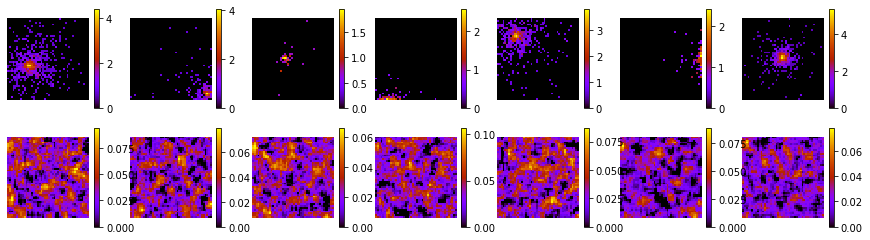

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:5017: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


100 [D real acc: 52.74%] [D fake acc: 53.43%] [G acc: 46.57%] 
200 [D real acc: 57.80%] [D fake acc: 52.38%] [G acc: 47.62%] 
300 [D real acc: 60.51%] [D fake acc: 51.76%] [G acc: 48.24%] 
400 [D real acc: 61.87%] [D fake acc: 51.80%] [G acc: 48.20%] 
500 [D real acc: 62.61%] [D fake acc: 52.05%] [G acc: 47.95%] 
600 [D real acc: 63.06%] [D fake acc: 52.26%] [G acc: 47.74%] 
700 [D real acc: 63.40%] [D fake acc: 52.88%] [G acc: 47.12%] 
800 [D real acc: 63.67%] [D fake acc: 54.02%] [G acc: 45.98%] 
900 [D real acc: 64.09%] [D fake acc: 54.31%] [G acc: 45.69%] 
1000 [D real acc: 64.25%] [D fake acc: 54.71%] [G acc: 45.29%] 


<Figure size 432x288 with 0 Axes>

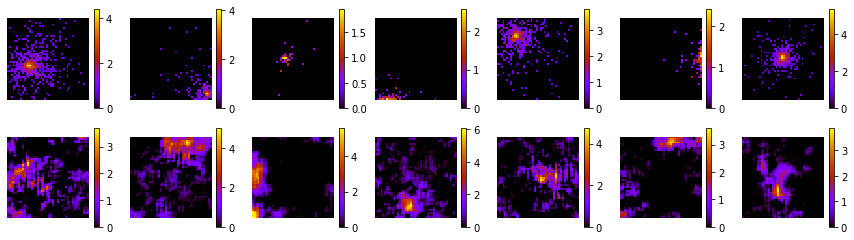

1100 [D real acc: 64.15%] [D fake acc: 55.21%] [G acc: 44.79%] 
1200 [D real acc: 64.09%] [D fake acc: 55.54%] [G acc: 44.46%] 
1300 [D real acc: 63.99%] [D fake acc: 55.98%] [G acc: 44.02%] 
1400 [D real acc: 63.81%] [D fake acc: 56.46%] [G acc: 43.54%] 
1500 [D real acc: 63.75%] [D fake acc: 56.88%] [G acc: 43.12%] 
1600 [D real acc: 63.65%] [D fake acc: 57.33%] [G acc: 42.67%] 
1700 [D real acc: 63.66%] [D fake acc: 57.82%] [G acc: 42.18%] 
1800 [D real acc: 63.65%] [D fake acc: 58.29%] [G acc: 41.71%] 


<Figure size 432x288 with 0 Axes>

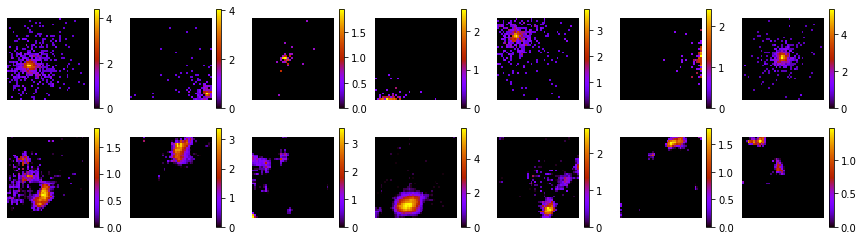

ws mean 914009859.75 ch1 7.35 ch2 3044384103.31 ch3 29.60 ch4 17.05 ch5 1525665141.44 Time for epoch 1 is 105.73067212104797 sec


<Figure size 432x288 with 0 Axes>

In [ ]:
history=train(dataset_with_cond, 1)

### Load best model described in thesis

In [ ]:
generator=tf.keras.models.load_model('./models/generator_GAN.h5')

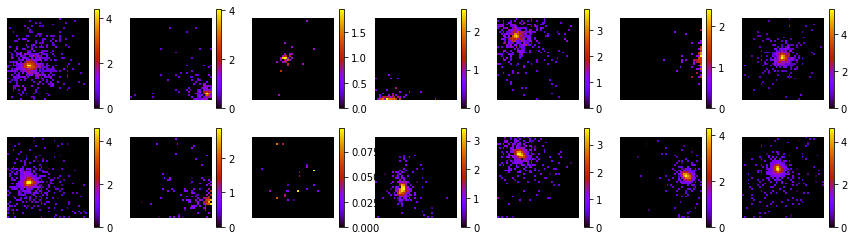

ws mean 8.26 ch1 4.34 ch2 5.46 ch3 7.34 ch4 9.12 ch5 15.06 

<Figure size 432x288 with 0 Axes>

In [ ]:
generate_and_save_images(generator,
                          25,
                          [seed, seed_cond]
                          )
calculate_ws_ch(5)